# Raw Risk Premias

This notebook will look at the raw risk premia returns that are generated by being long Fallen Angels and short some other bond ETF. The overall goal of this is to set a benchmark for the risk premia compensation. The idea will be to analyze the spread of being long Fallen Angels and Short a corresponding bond index. In this case both investment grade and high yield are used for shorts. Both equal weight and duration neutral spreads are tested. 

## Packages

In [1]:
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FallenAngel\root\src")
from RiskPremia import RiskPremia

## Getting Returns

In [3]:
def get_data() -> pd.DataFrame: 
    
    df_equal = (RiskPremia().calculate_equal_spread().assign(
        rtn = "equal").
        drop(columns = ["bnd_rtn", "angl_rtn"]))

    df_dur = (RiskPremia().calculate_duration_neutral_spread().assign(
        angl_rtn = lambda x: x.angl_rtn * x.angl_weight,
        bnd_rtn  = lambda x: x.bnd_rtn * x.bnd_weight,
        spread   = lambda x: x.angl_rtn - x.bnd_rtn,
        rtn      = "dur_neutral")
        [["date", "spread", "angl_sec", "bnd_sec", "rtn"]])

    df = (pd.concat([
        df_equal, df_dur]))
    
    return df

df = get_data()

## Examine Returns

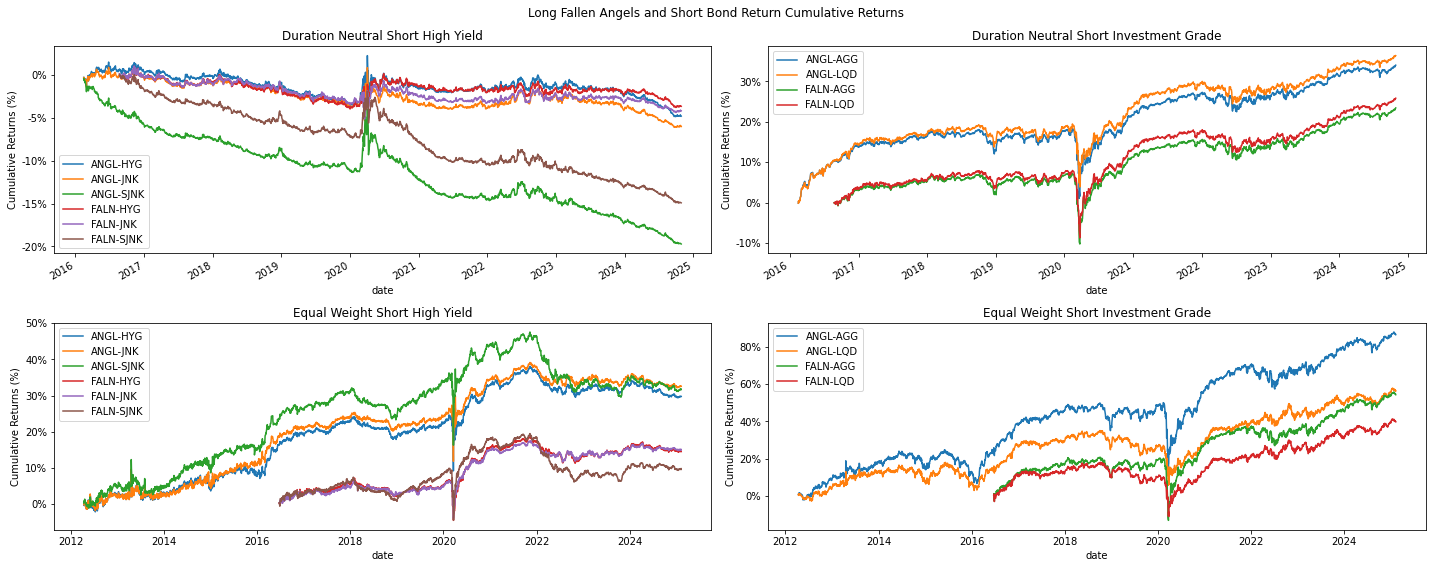

In [4]:
def plot_historical_return(df: pd.DataFrame) -> plt.Figure: 

    df_plot = (df.assign(
        ticker_spread = lambda x: x.angl_sec + "-" + x.bnd_sec,
        bond_group    = lambda x: np.where((x.bnd_sec == "AGG") | (x.bnd_sec == "LQD"), "ig", "hy"),
        group_var     = lambda x: x.rtn + "_" + x.bond_group))

    renamer = {
        "dur_neutral_hy": "Duration Neutral Short High Yield",
        "dur_neutral_ig": "Duration Neutral Short Investment Grade",
        "equal_hy"      : "Equal Weight Short High Yield",
        "equal_ig"      : "Equal Weight Short Investment Grade"}

    group_vars = df_plot.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 2, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_plot.query(
            "group_var == @group_var").
            rename(columns = {"ticker_spread": ""}).
            pivot(index = "date", columns = "", values = "spread").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                title  = renamer[group_var],
                ax     = ax,
                ylabel = "Cumulative Returns (%)"))
        
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    fig.suptitle("Long Fallen Angels and Short Bond Return Cumulative Returns")
    plt.tight_layout()
    
plot_historical_return(df)

In [5]:
def calculate_sharpe(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.drop(
        columns = ["date"]).
        groupby(["bnd_sec", "angl_sec", "rtn"]).
        agg(["mean", "std"])
        ["spread"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_out

df_sharpe = calculate_sharpe(df)

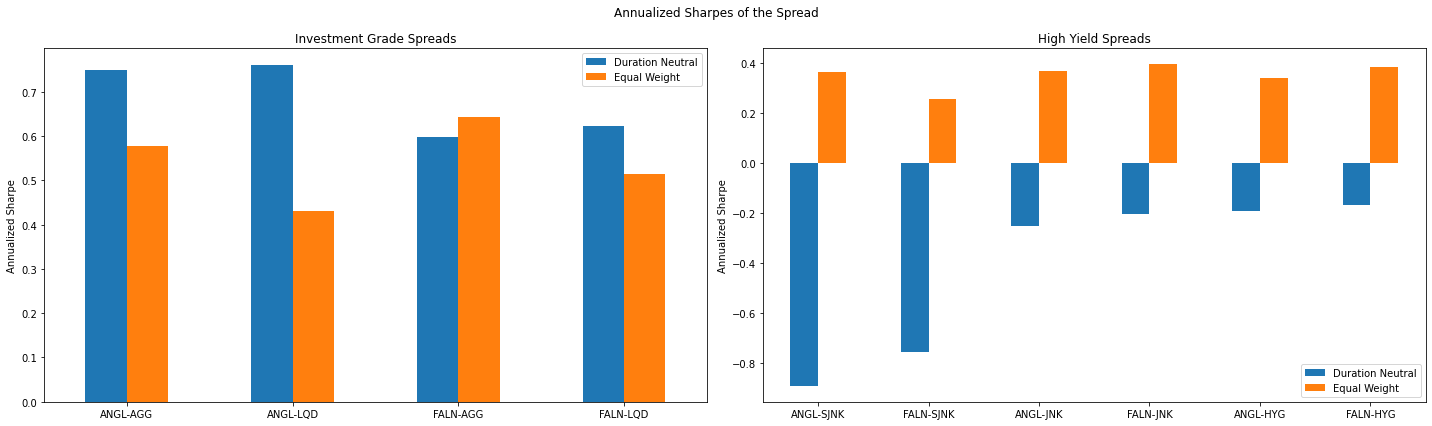

In [6]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure:
    
    fig, axes  = plt.subplots(ncols = 2, figsize = (20,6))
    ig_tickers = ["AGG", "LQD"]

    (df_sharpe.assign(
        spread_name = lambda x: x.angl_sec + "-" + x.bnd_sec).
        query("bnd_sec == @ig_tickers").
        rename(columns = {"rtn": ""}).
        pivot(index = "spread_name", columns = "", values = "sharpe").
        rename(columns = {
            "dur_neutral": "Duration Neutral",
            "equal"      : "Equal Weight"}).
        plot(
            kind   = "bar",
            rot    = 0,
            xlabel = "",
            ylabel = "Annualized Sharpe",
            ax     = axes[0],
            title  = "Investment Grade Spreads"))

    (df_sharpe.assign(
        spread_name = lambda x: x.angl_sec + "-" + x.bnd_sec).
        query("bnd_sec != @ig_tickers").
        rename(columns = {"rtn": ""}).
        pivot(index = "spread_name", columns = "", values = "sharpe").
        sort_values("dur_neutral").
        rename(columns = {
            "dur_neutral": "Duration Neutral",
            "equal"      : "Equal Weight"}).
        plot(
            kind   = "bar",
            rot    = 0,
            xlabel = "",
            ylabel = "Annualized Sharpe",
            ax     = axes[1],
            title  = "High Yield Spreads"))
    
    fig.suptitle("Annualized Sharpes of the Spread")
    plt.tight_layout()
    
plot_sharpe(df_sharpe)

## Comparing Weights

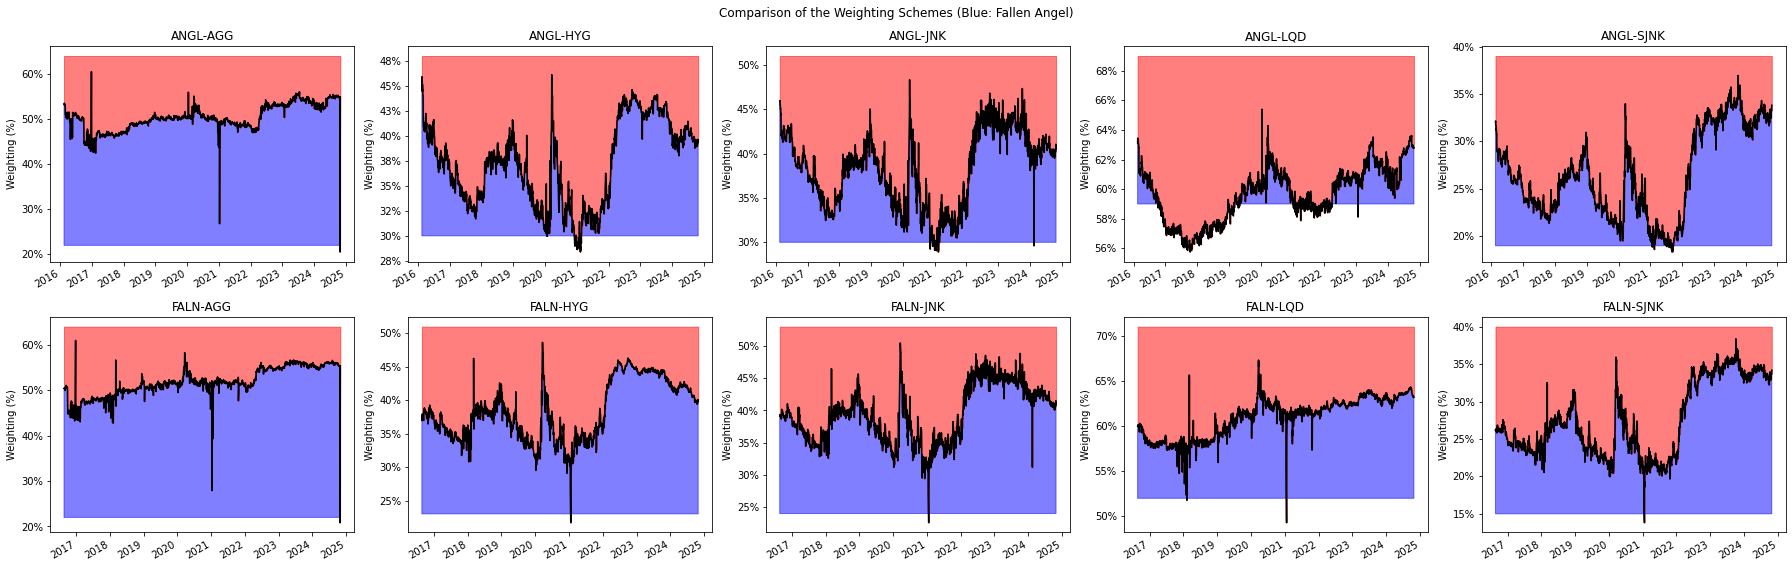

In [7]:
def plot_weights() -> plt.Figure:
    
    df_weights = RiskPremia().calculate_duration_neutral_spread()
    spreads   = df_weights.spread.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(spreads) // 2, nrows = len(spreads) // 5, figsize = (25,8))

    for spread, ax in zip(spreads, axes.flatten()): 

        df_plot = (df_weights.query(
            "spread == @spread").
            set_index("date"))

        (df_plot[
            ["angl_weight"]].
            plot(
                ax     = ax,
                legend = False,
                color  = "black",
                xlabel = "",
                title  = spread.replace("_", "-"),
                ylabel = "Weighting (%)"))

        min_cutoff = np.round(df_plot.angl_weight.min() * 1.05, 2)
        max_cutoff = np.round(df_plot.angl_weight.max() * 1.05, 2)

        ax.fill_between(
            x     = df_plot.index,
            y1    = min_cutoff,
            y2    = df_plot.angl_weight,
            where = df_plot.angl_weight > min_cutoff,
            color = "blue",
            alpha = 0.5)

        ax.fill_between(
            x     = df_plot.index,
            y1    = df_plot.angl_weight,
            y2    = max_cutoff,
            where = max_cutoff > df_plot.angl_weight,
            color = "red",
            alpha = 0.5)

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
        
    fig.suptitle("Comparison of the Weighting Schemes (Blue: Fallen Angel)")
    plt.tight_layout()
    
plot_weights()